### This Notebook is meant for creating an overview of the existing data of the cloud detection algorithm

## Import dependencies

In [2]:
from zipfile import ZipFile
import cv2
from pathlib import Path
import numpy as np
import os
from datetime import datetime
import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt


## Load Dataset.zip and extract

In [3]:
def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

zip_path = Path(r'C:\Users\Omar\Documents\ShadowMitigation\SKIPPD\CloudMask.zip')
dara = extract_zip(zip_path)

### Helper Function to Convert images

In [5]:
def convert_bytes(img_bytes):
  return  cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

#### Filter Pictures in hourly sequences

In [12]:
dataset = {}
for file_name, img_bytes in dara.items():

    x = Path(file_name).stem
    year, month, day, hour, minute = x[:4], x[4:6], x[6:8],x[8:10],x[10:12]

    key = f'{year}-{month}-{day}-{hour}'
    if key not in dataset.keys():
        dataset[key] = []

    dataset[key].append(file_name)

for key, value in dataset.items():
    dataset[key] = sorted(value)

for key, value in dataset.items():
  dataset[key] = [cv2.cvtColor(convert_bytes(dara[v]), cv2.COLOR_RGB2GRAY) for v in value]


faulty = []
correct = []
for k, v in dataset.items():
    if len(v) != 60:
        faulty.append(v)
    else:
        correct.append(v)


### Visualize Random Input Tensors


In [17]:
for i in range(5):
  rng = np.random.randint(0,len(correct)-1)
  v = correct[rng]
  input = np.array([img for img in v])[None, ...]
  for video in input[:32]:          # Loop over videos
      with io.BytesIO() as gif:
          imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
          display(HBox([widgets.Image(value=gif.getvalue())]))


### Explore Dataset

In [18]:
SKIPPD = np.array(correct, dtype=np.float32) / 255

In [58]:
# Compute the sum of each image and sequence using numpy operations
im_sums = np.sum(SKIPPD, axis=(2, 3))  # Sum over height and width for each image
sequence_sums = np.sum(im_sums, axis=1)  # Sum over images for each sequence

# Calculate statistics for image sums
max_im_sum, min_im_sum, mean_im_sum = np.max(im_sums), np.min(im_sums), np.mean(im_sums)
# Calculate statistics for sequence sums
max_seq_sum, min_seq_sum, mean_seq_sum = np.max(sequence_sums), np.min(sequence_sums), np.mean(sequence_sums)

# Find indices of max and min sums
max_im_idx = np.unravel_index(np.argmax(im_sums), im_sums.shape)
min_im_idx = np.unravel_index(np.argmin(im_sums), im_sums.shape)
max_seq_idx = np.argmax(sequence_sums)
min_seq_idx = np.argmin(sequence_sums)
total_images = im_sums.size
average_im_sum = mean_im_sum
total_im_sum = np.sum(im_sums)

print(f"Image Sums - Max: {max_im_sum}, Min: {min_im_sum}, Mean: {mean_im_sum}")
print(f"Max Image Index: {max_im_idx}, Min Image Index: {min_im_idx}")
print(f"Sequence Sums - Max: {max_seq_sum}, Min: {min_seq_sum}, Mean: {mean_seq_sum}")
print(f"Max Sequence Index: {max_seq_idx}, Min Sequence Index: {min_seq_idx}")

Image Sums - Max: 1530.796142578125, Min: 0.0, Mean: 382.69122314453125
Max Image Index: (1054, 16), Min Image Index: (10, 28)
Sequence Sums - Max: 88391.2109375, Min: 0.0, Mean: 22961.4765625
Max Sequence Index: 394, Min Sequence Index: 54


In [49]:

def sequence_gif(sequence):
  inp = np.array([img for img in sequence])[None, ...]*255
  for video in inp  :          # Loop over videos
      with io.BytesIO() as gif:
          imageio.mimsave(gif,video,"GIF",fps=5)
          display(HBox([widgets.Image(value=gif.getvalue())]))

In [51]:
sequence_gif(SKIPPD[max_seq_idx])

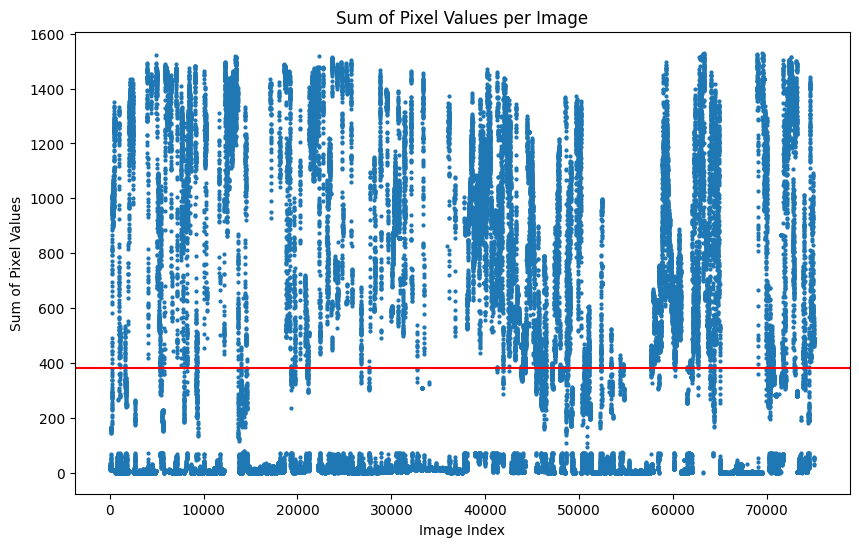

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(im_sums.flatten(), marker='o', linestyle='', markersize=2)
plt.title('Sum of Pixel Values per Image')
plt.xlabel('Image Index')
plt.ylabel('Sum of Pixel Values')
plt.axhline(y=im_sums.mean(), color='r', linestyle='-')

plt.show()


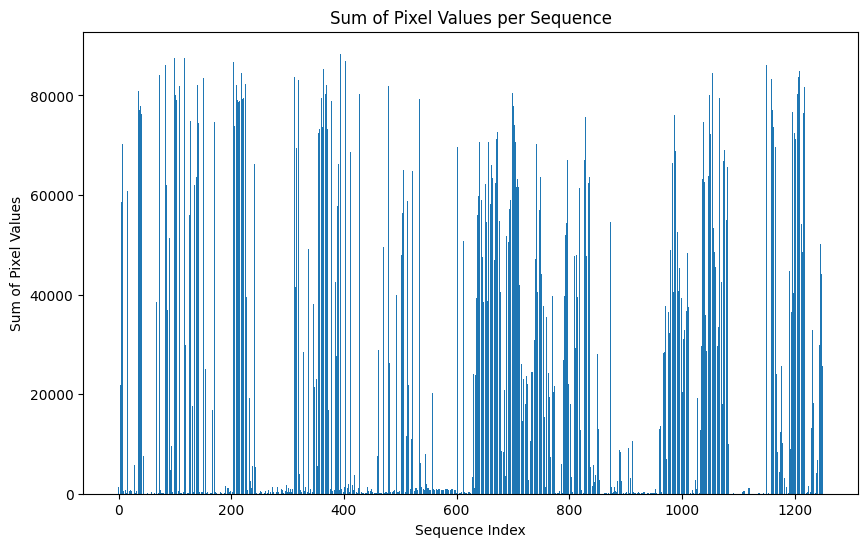

In [55]:
plt.figure(figsize=(10, 6))
plt.bar(range(total_sequences), sequence_sums)
plt.title('Sum of Pixel Values per Sequence')
plt.xlabel('Sequence Index')
plt.ylabel('Sum of Pixel Values')
plt.show()


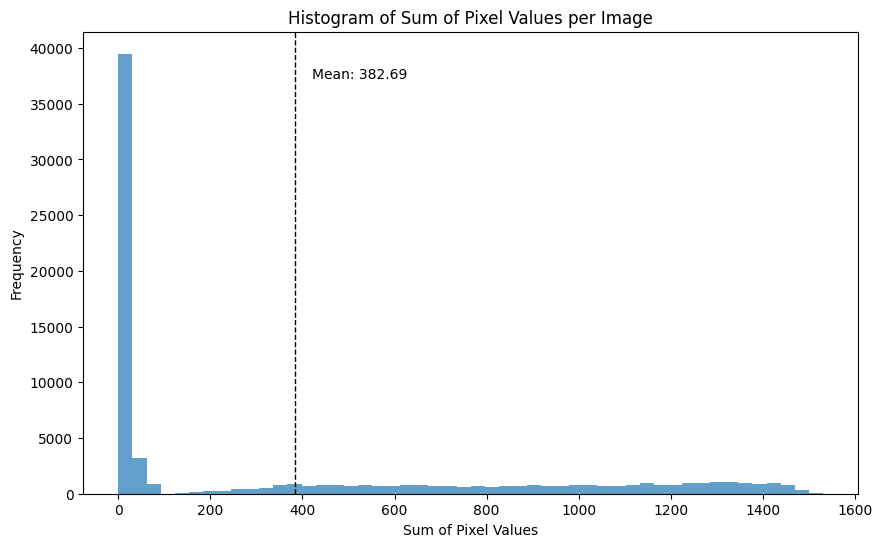

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(im_sums.flatten(), bins=50, alpha=0.7)
plt.axvline(im_sums.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(im_sums.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(im_sums.mean()))
plt.title('Histogram of Sum of Pixel Values per Image')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.show()

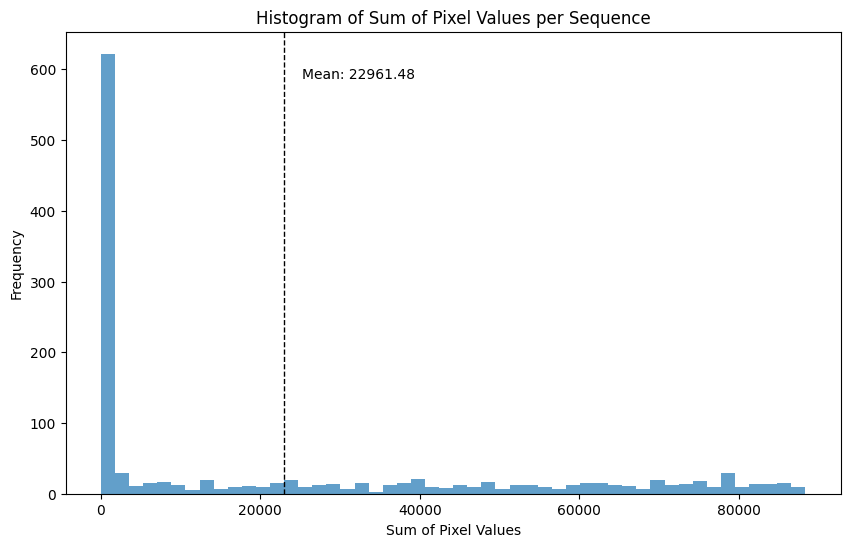

In [64]:
plt.figure(figsize=(10, 6))
plt.hist(sequence_sums.flatten(), bins=50, alpha=0.7)
plt.axvline(sequence_sums.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(sequence_sums.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(sequence_sums.mean()))
plt.title('Histogram of Sum of Pixel Values per Sequence')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.show()


In [59]:
std_im_sum = np.std(im_sums)
outliers = np.where((im_sums > average_im_sum + 2 * std_im_sum) | (im_sums < average_im_sum - 2 * std_im_sum))
print(f"Outlier indices (sequence, image): {outliers}")


Outlier indices (sequence, image): (array([  35,   35,   35, ..., 1243, 1243, 1243], dtype=int64), array([27, 28, 29, ..., 50, 51, 52], dtype=int64))
